# build-langgraph-engineer

Explore and test the main components of LangGraph Engineer.

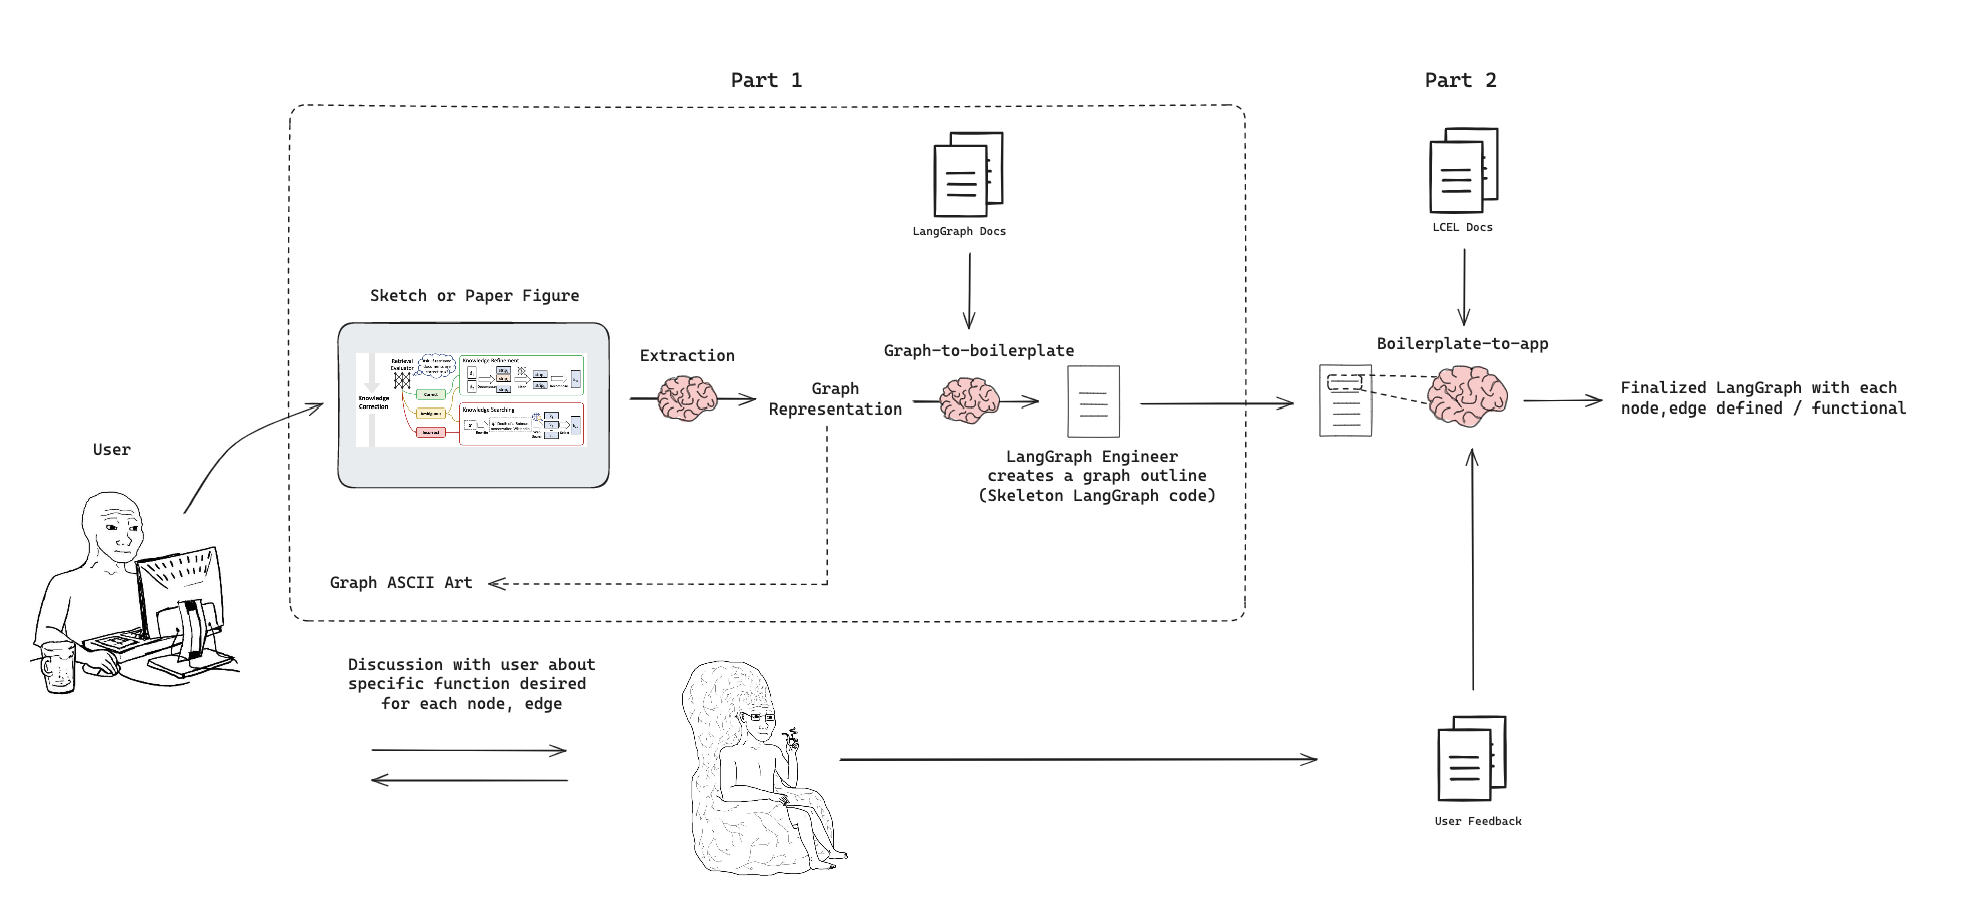

# Part 1: `Image-to-Boilerplate`

## Inputs

In [1]:
## Docs

from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LangGraph docs 
url = "https://python.langchain.com/docs/langgraph/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# CRAG ntbk
markdown_path = "ntbk_code_examples/langgraph_crag_code_only.md"
loader = UnstructuredMarkdownLoader(markdown_path)
docs.extend(loader.load())

# Self-RAG ntbk
markdown_path = "ntbk_code_examples/langgraph_self_rag_code_only.md"
loader = UnstructuredMarkdownLoader(markdown_path)
docs.extend(loader.load())

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content'
langgraph_docs = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

### User image

In [2]:
import os
import base64
from pathlib import Path

def encode_image(image_path):
    """Getting the base64 string"""
    img_base64 = base64.b64encode(Path(image_path).read_bytes()).decode("utf-8")
    return img_base64

image_path = "CRAG.jpg"
img_base_64 = encode_image(image_path)

## Multi modal LLM

In [3]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

multi_modal_model = ChatAnthropic(temperature=0, model='claude-3-opus-20240229')
multi_modal_model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview",max_tokens="1028")

### Image-to-code test

In [5]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.output_parsers.openai_tools import PydanticToolsParser

template="""Here are the full LangGrah docs: \n --- --- --- \n {docs} \n --- --- --- \n 
            You will be shown an image of a graph with nodes as circles and edges \n
            as squares. Each node and edge has a label. Use the provided LangGraph docs to convert \n
            the image into a LangGraph graph. This will have 3 things: (1) create a dummy \n
            state value. (2) Define a dummy function for each each node or edge. (3) finally \n
            create the graph workflow that connects all edges and nodes together. \n
            Structure your answer with a description of the code solution. \n
            Then list the imports. And finally list the functioning code block.""" 

prompt = ChatPromptTemplate.from_messages(
        [("system", "You are an expert in converting graph visualizations into LangGrah."),
         ("human",[
             {"type": "text", "text": template},
             {"type": "image_url","image_url": "data:image/jpeg;base64,{my_image}"}
                ],
         ),
        ]
    ) 

prompt_anthropic = ChatPromptTemplate.from_messages(
        [("human",[
             {"type": "text", "text": template},
             {"type": "image_url","image_url": "data:image/jpeg;base64,{my_image}"}
                ],
         ),
        ]
    ) 


chain = (
    prompt_anthropic
    | multi_modal_model 
)

code_solution = chain.invoke({"my_image": img_base_64, "docs": langgraph_docs})

In [6]:
def format_code(code_solution):

    template="""You are an expert a code formatting, strating with a code solution \n
                \n --- --- \n {code} \n --- --- \n Structure the solution in three parts \n
                with a prefix that defines the problem, then list the imports, and finally \n
                list the functioning code block.""" 
    
    prompt = ChatPromptTemplate.from_messages(
            [("system", "You are an expert at code formatting."),
             ("human",[
                 {"type": "text", "text": template},
                    ],
             ),
            ]
        ) 
    
    ## Data model
    class code(BaseModel):
        """Code output"""
        prefix: str = Field(description="Description of the problem and approach")
        imports: str = Field(description="Code block import statements")
        code: str = Field(description="Code block not including import statements")
    
    ## LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview")
    
    # Tool
    code_tool_oai = convert_to_openai_tool(code)
    
    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[code_tool_oai],
        tool_choice={"type": "function", "function": {"name": "code"}},
    )
    
    # Parser
    parser_tool = PydanticToolsParser(tools=[code])
    
    chain = (
        prompt
        | llm_with_tool 
        | parser_tool
    )
    
    formatted_code = chain.invoke({"code": code_solution})

    return formatted_code

formatted_code = format_code(code_solution)

In [7]:
formatted_code[0].prefix

"Here is how we can implement the graph shown in the image using LangGraph:\n\nDescription:\nThe graph represents a workflow for a corrective RAG (Retrieval-Augmented Generation) system using local LLMs. It starts with a question, retrieves relevant documents, grades them to determine if they are sufficient to answer the question. If not, it re-writes the query and performs a web search. The search results are then used to generate a final answer.\n\nWe'll define a GraphState to hold the relevant data, dummy functions for each node and edge, and then build the graph connecting the nodes and edges."

In [8]:
formatted_code[0].imports

'import operator\nfrom typing import Annotated, Sequence\n\nfrom langchain_core.messages import BaseMessage\nfrom langgraph.graph import StateGraph, END'

In [9]:
formatted_code[0].code

'# Define graph state\nclass GraphState(TypedDict):\n    question: str\n    retrieved_docs: Annotated[Sequence[str], operator.add] \n    rewritten_query: str\n    web_search_results: Annotated[Sequence[str], operator.add]\n    answer: str\n\n# Define dummy node functions\ndef retrieve(state):\n    # Dummy retrieve function \n    return {"retrieved_docs": ["doc1", "doc2"]}\n\ndef grade(state):\n    # Dummy grade function\n    if len(state["retrieved_docs"]) > 1:\n        return "Yes"\n    else:\n        return "No"\n\ndef generate(state):\n    # Dummy generate function\n    return {"answer": "This is the generated answer"}\n\ndef rewrite_query(state):\n    # Dummy rewrite query function \n    return {"rewritten_query": "rewritten query"}\n\ndef web_search(state):\n    # Dummy web search function\n    return {"web_search_results": ["result1", "result2"]}\n\n# Define dummy edge functions  \ndef any_doc_irrelevant(state):\n    if state["grade"] == "No":\n        return "Yes" \n    else:\n 

# Graph

Add code checks

In [13]:
from bs4 import BeautifulSoup as Soup
from operator import itemgetter

from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate 
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool

def format_code(code_solution):

    """
    Convert code solution to structured object

    Args:
        code_solution (str): Code solution from LLM

    Returns:
        code_solution (BaseModel): Structured object
    """

    template="""You are an expert a code formatting, strating with a code solution \n
                \n --- --- \n {code} \n --- --- \n Structure the solution in three parts \n
                with a prefix that defines the problem, then list the imports, and finally \n
                list the functioning code block.""" 
    
    prompt = ChatPromptTemplate.from_messages(
            [("system", "You are an expert at code formatting."),
             ("human",[
                 {"type": "text", "text": template},
                    ],
             ),
            ]
        ) 
    
    ## Data model
    class code(BaseModel):
        """Code output"""
        prefix: str = Field(description="Description of the problem and approach")
        imports: str = Field(description="Code block import statements")
        code: str = Field(description="Code block not including import statements")
    
    ## LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview")
    
    # Tool
    code_tool_oai = convert_to_openai_tool(code)
    
    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[code_tool_oai],
        tool_choice={"type": "function", "function": {"name": "code"}},
    )
    
    # Parser
    parser_tool = PydanticToolsParser(tools=[code])
    
    chain = (
        prompt
        | llm_with_tool 
        | parser_tool
    )
    
    formatted_code = chain.invoke({"code": code_solution})

    return formatted_code

def generate(state):
    """
    Generate a code solution based on LangGrapj docs and the input image 
    with optional feedback from code execution tests 

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    ## State
    state_dict = state["keys"]
    iter = state_dict["iterations"]

    template="""Here are the full LangGrah docs: \n --- --- --- \n {docs} \n --- --- --- \n 
            You will be shown an image of a graph with nodes as circles and edges \n
            as squares. Each node and edge has a label. Use the provided LangGraph docs to convert \n
            the image into a LangGraph graph. This will have 3 things: (1) create a dummy \n
            state value. (2) Define a dummy function for each each node or edge. (3) finally \n
            create the graph workflow that connects all edges and nodes together. \n
            Structure your answer with a description of the code solution. \n
            Then list the imports. And finally list the functioning code block.""" 
 
    ## Generation
    if "error" in state_dict:
        print("---RE-GENERATE SOLUTION w/ ERROR FEEDBACK---")
        
        error = state_dict["error"]
        code_solution = state_dict["generation"]
        
        # Udpate prompt 
        addendum = """  \n --- --- --- \n You previously tried to solve this problem. \n Here is your solution:  
                    \n --- --- --- \n {generation}  \n --- --- --- \n  Here is the resulting error from code 
                    execution:  \n --- --- --- \n {error}  \n --- --- --- \n Please re-try to answer this."""
        template = template +  addendum

        prompt = ChatPromptTemplate.from_messages(
                [("system", "You are an expert in converting graph visualizations into runnable LangGrah code."),
                 ("human",[
                     {"type": "text", "text": template},
                     {"type": "image_url","image_url": "data:image/jpeg;base64,{my_image}"}
                        ],
                 ),
                ]
            ) 

        chain = (
            prompt
            | multi_modal_model 
        )
        
        code_solution = chain.invoke({"my_image": img_base_64,
                                      "docs": langgraph_docs,
                                      "generation": str(code_solution[0]),
                                      "error": error} )

        code_solution_formatted = format_code(code_solution)
        
                        
    else:
        print("---GENERATE SOLUTION---")
        
        prompt = ChatPromptTemplate.from_messages(
                [("system", "You are an expert in converting graph visualizations into runnable LangGrah code."),
                 ("human",[
                     {"type": "text", "text": template},
                     {"type": "image_url","image_url": "data:image/jpeg;base64,{my_image}"}
                        ],
                 ),
                ]
            ) 
        
        chain = (
            prompt
            | multi_modal_model 
        )
        
        code_solution = chain.invoke({"my_image": img_base_64, "docs": langgraph_docs})

        code_solution_formatted = format_code(code_solution)

    iter = iter+1 
    return {"keys": {"generation": code_solution_formatted, "iterations":iter}}

def check_code_imports(state):
    """
    Check imports

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """
    
    ## State
    print("---CHECKING CODE IMPORTS---")
    state_dict = state["keys"]
    code_solution = state_dict["generation"]
    imports = code_solution[0].imports
    iter = state_dict["iterations"]

    try:        
        # Attempt to execute the imports
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        # Catch any error during execution (e.g., ImportError, SyntaxError)
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error     
    else:
        print("---CODE IMPORT CHECK: SUCCESS---")
        # No errors occurred
        error = "None"

    return {"keys": {"generation": code_solution, "error": error, "iterations":iter}}

def check_code_execution(state):
    """
    Check code block execution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """
    
    ## State
    print("---CHECKING CODE EXECUTION---")
    state_dict = state["keys"]
    code_solution = state_dict["generation"]
    prefix = code_solution[0].prefix
    imports = code_solution[0].imports
    code = code_solution[0].code
    code_block = imports +"\n"+ code
    iter = state_dict["iterations"]

    try:        
        # Attempt to execute the code block
        exec(code_block)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        print(f"---FAILED code: {code_solution}---")
        # Catch any error during execution (e.g., ImportError, SyntaxError)
        error = f"Execution error: {e}"
        if "error" in state_dict:
            error_prev_runs = state_dict["error"]
            error = error_prev_runs + "\n --- Most recent run error --- \n" + error  
    else:
        print("---CODE BLOCK CHECK: SUCCESS---")
        # No errors occurred
        error = "None"

    return {"keys": {"generation": code_solution, 
                     "error": error, 
                     "prefix":prefix,
                     "imports":imports,
                     "iterations":iter,
                     "code":code}}

### Edges

def decide_to_check_code_exec(state):
    """
    Determines whether to test code execution, or re-try answer generation.

    Args:
       state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    code_solution = state_dict["generation"]
    error = state_dict["error"]

    if error == "None":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "check_code_execution"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

def decide_to_finish(state):
    """
    Determines whether to finish (re-try code 3 times.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---DECIDE TO TEST CODE EXECUTION---")
    state_dict = state["keys"]
    code_solution = state_dict["generation"]
    error = state_dict["error"]
    iter = state_dict["iterations"]

    if error == "None" or iter == 3:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: TEST CODE EXECUTION---")
        return "end"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

In [14]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

In [15]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("generate", generate)  # generation solution
workflow.add_node("check_code_imports", check_code_imports)  # check imports
workflow.add_node("check_code_execution", check_code_execution)  # check execution

# Build graph
workflow.set_entry_point("generate")
workflow.add_edge("generate", "check_code_imports")
workflow.add_conditional_edges(
    "check_code_imports",
    decide_to_check_code_exec,
    {
        "check_code_execution": "check_code_execution",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "check_code_execution",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

# Compile
app = workflow.compile()

In [16]:
# Run
import pprint
inputs = {"keys": {"my_image": img_base_64, "docs": langgraph_docs, "iterations":0}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["keys"]["generation"])

---GENERATE SOLUTION---
"Node 'generate':"
'\n---\n'
---CHECKING CODE IMPORTS---
---CODE IMPORT CHECK: SUCCESS---
"Node 'check_code_imports':"
'\n---\n'
---DECIDE TO TEST CODE EXECUTION---
---DECISION: TEST CODE EXECUTION---
---CHECKING CODE EXECUTION---
---CODE BLOCK CHECK: FAILED---
---FAILED code: [code(prefix='The following Python code demonstrates how to implement a workflow in LangGraph based on a given graph structure. This structure involves a series of nodes and edges representing a "Corrective RAG with local LLMs" system. The workflow starts with a question node, progresses through various processing stages depending on the relevance of documents retrieved, and ultimately generates an answer. The implementation includes defining a dummy GraphState to represent data passed between nodes, creating dummy functions for each node and edge, and setting up the StateGraph with the specified nodes and edges.', imports='from typing import TypedDict\nfrom langgraph.graph import StateGra

In [17]:
from IPython.display import Markdown

def render_code(output):

    code_output = output['__end__']['keys']['generation'][0]
    return Markdown(f'''```{code_output.code}```''')

render_code(output)

```# Define dummy GraphState 
class GraphState(TypedDict):
    question: str
    retrieved_docs: list
    graded_docs: list 
    rewritten_query: str
    web_search_results: list
    answer: str

# Define dummy node functions
def retrieve(state):
    # Dummy retrieve function 
    return {"retrieved_docs": ["doc1", "doc2"]}

def grade(state):
    # Dummy grade function
    return {"graded_docs": ["doc1"]}  

def rewrite_query(state):
    # Dummy rewrite query function
    return {"rewritten_query": "new query"}

def web_search(state):  
    # Dummy web search function
    return {"web_search_results": ["result1", "result2"]}

def generate(state):
    # Dummy generate function 
    return {"answer": "final answer"}

# Define dummy edge function  
def grade_docs(state):
    # Dummy grade docs conditional function
    if "doc2" in state["graded_docs"]:
        return "generate" 
    else:
        return "rewrite_query"

# Create graph
workflow = StateGraph(GraphState)

# Add nodes  
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade", grade)
workflow.add_node("rewrite_query", rewrite_query)  
workflow.add_node("web_search", web_search)
workflow.add_node("generate", generate)

# Add edges
workflow.set_entry_point("retrieve") 
workflow.add_edge("retrieve", "grade")
workflow.add_conditional_edges("grade", grade_docs, {
    "generate": "generate",
    "rewrite_query": "rewrite_query"
})
workflow.add_edge("rewrite_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile graph 
app = workflow.compile()```

`Ground Truth` -- 

In [101]:
### Build graph

### State 

from typing import Dict, TypedDict
from langchain_core.messages import BaseMessage

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]
    
from langgraph.graph import END, StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()